In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path[:3]

['/data/pinello/PROJECTS/2019_08_Embedding/SIMBA_RESULTS/multiome_shareseq_skin',
 '/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python37.zip',
 '/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7']

In [3]:
sys.path.insert(1,'/data/pinello/PROJECTS/2019_08_Embedding/Github/simba/')
sys.path[:3]

['/data/pinello/PROJECTS/2019_08_Embedding/SIMBA_RESULTS/multiome_shareseq_skin',
 '/data/pinello/PROJECTS/2019_08_Embedding/Github/simba/',
 '/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python37.zip']

In [4]:
import simba as si
import os
si.__path__

['/data/pinello/PROJECTS/2019_08_Embedding/Github/simba/simba']

In [5]:
import numpy as np
import pandas as pd

In [6]:
workdir = 'result_shareseq_multiome_fig4_v5'
si.settings.set_workdir(workdir)

Saving results in: result_shareseq_multiome_fig4_v5


In [7]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

## ATAC-seq

### preprocessing

In [8]:
adata_CP = si.read_h5ad("./input/data_processed/multiome/atac_seq_fig4.h5ad")

In [9]:
adata_CP

AnnData object with n_obs × n_vars = 6436 × 344592
    obs: 'depth', 'FRIP', 'TSSportion', 'EnhancerPortion', 'atac.barcode', 'rna.barcode', 'atac.umap1', 'atac.umap2', 'celltype', 'rna.umap1', 'rna.umap2'
    var: 'chr', 'start', 'end', 'width', 'strand', 'TSSidx', 'Enhanceridx', 'Gene', 'peaks'

In [10]:
adata_CP.var.head()

,chr,start,end,width,strand,TSSidx,Enhanceridx,Gene,peaks
chr1_3094822_3095122,chr1,3094822,3095122,301,*,False,True,Cln8,chr1_3094822
chr1_3119862_3120162,chr1,3119862,3120162,301,*,False,True,H2-K1,chr1_3119862
chr1_3268180_3268480,chr1,3268180,3268480,301,*,False,False,Lsm3,chr1_3268180
chr1_3292541_3292841,chr1,3292541,3292841,301,*,False,False,Mtmr3,chr1_3292541
chr1_3514811_3515111,chr1,3514811,3515111,301,*,False,False,Mapk6,chr1_3514811


In [11]:
# si.pp.filter_cells_atac(adata,min_n_genes=100)
si.pp.filter_peaks(adata_CP,min_n_cells=3)

Before filtering: 
6436 cells, 344592 peaks
Filter peaks based on min_n_cells


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


After filtering out low-expressed peaks: 
6436 cells, 332987 peaks


In [12]:
si.pp.cal_qc_atac(adata_CP)

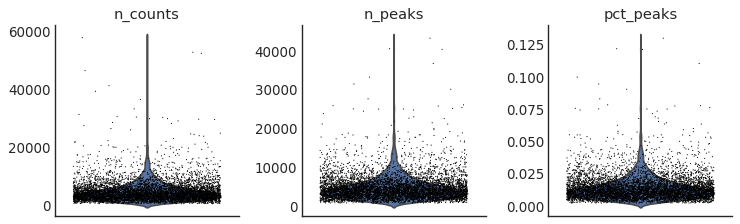

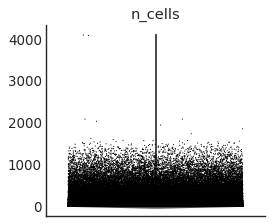

In [13]:
si.pl.violin(adata_CP,list_obs=['n_counts','n_peaks','pct_peaks'], list_var=['n_cells'])

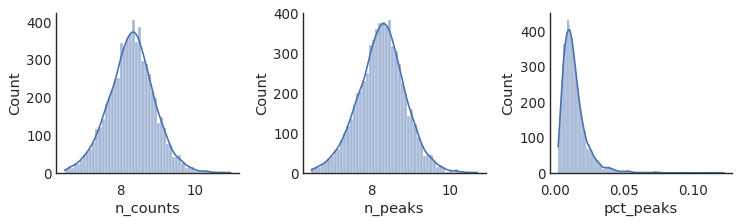

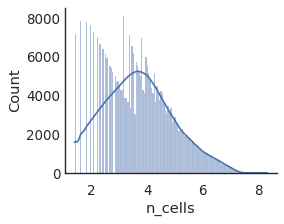

In [14]:
si.pl.hist(adata_CP,list_obs=['n_counts','n_peaks','pct_peaks'], log=True, list_var=['n_cells'])

### select peaks (optional but suggested)

> it will speed up the trainning process while only keeping peaks associated with top PCs

In [15]:
# si.pp.pca(adata_CP, n_components=40)

In [16]:
# si.pl.pca_variance_ratio(adata_CP)

In [17]:
#The number of selected PCs can be further reduced
# si.pp.select_pcs(adata_CP,n_pcs=40)

In [18]:
# si.pp.select_pcs_features(adata_CP)

In [19]:
# si.pl.pcs_features(adata_CP, fig_size=(3,3), fig_ncol=6)

### scan selected peaks for kmers and motifs

In [20]:
peaks_selected = adata_CP.var[['chr','start','end']]

In [21]:
peaks_selected.to_csv(os.path.join(workdir,'peaks_selected.bed'),sep='\t',header=False,index=False)

* Run provided R script under the result directory  
```bash
Rscript ./scan_for_kmers_motifs_modified.R -i peaks_selected.bed -g ../input/mm10/mm10.fa -s 'Mus musculus'
```

In [22]:
adata_PK = si.read_hdf(os.path.join(workdir,'output_kmers_motifs/freq_kmer.h5'),'mat')
adata_PM = si.read_hdf(os.path.join(workdir,'output_kmers_motifs/freq_motif.h5'),'mat')

In [23]:
# convert byte string to string
adata_PK.obs.index = [x.decode('utf-8') for x in adata_PK.obs.index]
adata_PK.var.index = [x.decode('utf-8') for x in adata_PK.var.index]

adata_PM.obs.index = [x.decode('utf-8') for x in adata_PM.obs.index]
adata_PM.var.index = [x.decode('utf-8') for x in adata_PM.var.index]

In [24]:
adata_PK

AnnData object with n_obs × n_vars = 332987 × 4096

In [25]:
adata_PM

AnnData object with n_obs × n_vars = 332987 × 884

In [26]:
adata_PM.obs.head()

""
chr1_3094822_3095122
chr1_3292541_3292841
chr1_3514811_3515111
chr1_3670440_3670740
chr1_3670860_3671160


In [27]:
si.pp.binarize(adata_PK)
si.pp.binarize(adata_PM)

In [28]:
# si.pp.pca(adata_PK, n_components=30)
# si.pp.pca(adata_PM, n_components=30)

In [29]:
# si.pp.select_pcs_features(adata_PK, min_elbow=adata_PK.shape[1]/5, S=5)
# si.pp.select_pcs_features(adata_PM, min_elbow=adata_PM.shape[1]/5, S=5)

In [30]:
# si.pl.pcs_features(adata_PK ,fig_size=(3,3), fig_ncol=6)

In [31]:
# si.pl.pcs_features(adata_PM ,fig_size=(3,3), fig_ncol=6)

In [32]:
adata_PK

AnnData object with n_obs × n_vars = 332987 × 4096

In [33]:
adata_PM

AnnData object with n_obs × n_vars = 332987 × 884

## RNA-seq

In [34]:
adata_CG = si.read_h5ad("./input/data_processed/multiome/rna_seq_fig4.h5ad")

In [35]:
adata_CG

AnnData object with n_obs × n_vars = 6436 × 20331
    obs: 'celltype'

In [36]:
si.pp.filter_genes(adata_CG,min_n_cells=3)

Before filtering: 
6436 cells, 20331 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
6436 cells, 17399 genes


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [37]:
si.pp.cal_qc_rna(adata_CG)

In [38]:
si.pp.normalize(adata_CG,method='lib_size')

In [39]:
si.pp.log_transform(adata_CG)

In [40]:
# si.pp.select_variable_genes(adata_CG)

In [41]:
# si.pl.variable_genes(adata_CG,show_texts=True)

In [42]:
si.tl.discretize(adata_CG,n_bins=5)

[0.54990256 1.6044493  2.161982   2.770135   4.2600927  8.499525  ]


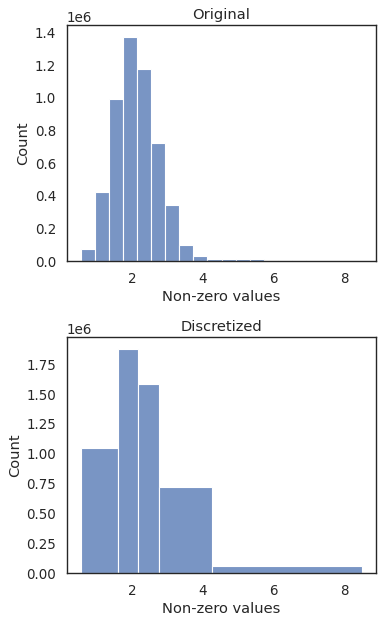

In [43]:
si.pl.discretize(adata_CG,kde=False)

## Generate Graph

In [44]:
si.tl.gen_graph(list_CP=[adata_CP],
                list_CG=[adata_CG],
                list_PK=[adata_PK],
                list_PM=[adata_PM],
                copy=False,
                use_highly_variable=False,
                use_top_pcs=False,
                dirname='graph0')

relation0: source: C, destination: P
#edges: 29715636
relation1: source: P, destination: M
#edges: 11851328
relation2: source: P, destination: K
#edges: 90598213
relation3: source: C, destination: G
#edges: 1046833
relation4: source: C, destination: G
#edges: 1877327
relation5: source: C, destination: G
#edges: 1580227
relation6: source: C, destination: G
#edges: 717081
relation7: source: C, destination: G
#edges: 59974
Total number of edges: 137446619
Writing graph file "pbg_graph.txt" to "result_shareseq_multiome_fig4_v5/pbg/graph0" ...
Finished.


## PBG training

In [45]:
si.settings.pbg_params

{'entity_path': 'result_shareseq_multiome_fig4_v5/pbg/graph0/input/entity',
 'edge_paths': ['result_shareseq_multiome_fig4_v5/pbg/graph0/input/edge'],
 'checkpoint_path': '',
 'entities': {'C': {'num_partitions': 1},
  'G': {'num_partitions': 1},
  'P': {'num_partitions': 1},
  'K': {'num_partitions': 1},
  'M': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'P',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'P', 'rhs': 'M', 'operator': 'none', 'weight': 0.2},
  {'name': 'r2', 'lhs': 'P', 'rhs': 'K', 'operator': 'none', 'weight': 0.02},
  {'name': 'r3', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 1.0},
  {'name': 'r4', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r5', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r6', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
  {'name': 'r7', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 5.0}],
 'dynamic_relations

In [46]:
dict_config = si.settings.pbg_params.copy()
## start training
# dict_config['wd'] = 0.00015
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, output='model')

Auto-estimated weight decay is 0.000172
Converting input data ...
[2021-04-29 15:55:38.118993] Using the 8 relation types given in the config
[2021-04-29 15:55:38.119543] Searching for the entities in the edge files...
[2021-04-29 15:58:54.761559] Entity type C:
[2021-04-29 15:58:54.763001] - Found 6436 entities
[2021-04-29 15:58:54.763342] - Removing the ones with fewer than 1 occurrences...
[2021-04-29 15:58:54.765454] - Left with 6436 entities
[2021-04-29 15:58:54.765761] - Shuffling them...
[2021-04-29 15:58:54.770086] Entity type G:
[2021-04-29 15:58:54.770419] - Found 17399 entities
[2021-04-29 15:58:54.770706] - Removing the ones with fewer than 1 occurrences...
[2021-04-29 15:58:54.772948] - Left with 17399 entities
[2021-04-29 15:58:54.773264] - Shuffling them...
[2021-04-29 15:58:54.784876] Entity type P:
[2021-04-29 15:58:54.785212] - Found 332987 entities
[2021-04-29 15:58:54.785511] - Removing the ones with fewer than 1 occurrences...
[2021-04-29 15:58:54.927411] - Left wi

[2021-04-29 15:59:44.727558] - Processed 9100000 edges so far...
[2021-04-29 15:59:45.260189] - Processed 9200000 edges so far...
[2021-04-29 15:59:45.810843] - Processed 9300000 edges so far...
[2021-04-29 15:59:46.336089] - Processed 9400000 edges so far...
[2021-04-29 15:59:46.861073] - Processed 9500000 edges so far...
[2021-04-29 15:59:47.405266] - Processed 9600000 edges so far...
[2021-04-29 15:59:47.936209] - Processed 9700000 edges so far...
[2021-04-29 15:59:48.463764] - Processed 9800000 edges so far...
[2021-04-29 15:59:48.993360] - Processed 9900000 edges so far...
[2021-04-29 15:59:49.523224] - Processed 10000000 edges so far...
[2021-04-29 15:59:50.073823] - Processed 10100000 edges so far...
[2021-04-29 15:59:50.602059] - Processed 10200000 edges so far...
[2021-04-29 15:59:51.143783] - Processed 10300000 edges so far...
[2021-04-29 15:59:51.670163] - Processed 10400000 edges so far...
[2021-04-29 15:59:52.198984] - Processed 10500000 edges so far...
[2021-04-29 15:59:5

[2021-04-29 16:00:51.809179] - Processed 21600000 edges so far...
[2021-04-29 16:00:52.330936] - Processed 21700000 edges so far...
[2021-04-29 16:00:52.853921] - Processed 21800000 edges so far...
[2021-04-29 16:00:53.373549] - Processed 21900000 edges so far...
[2021-04-29 16:00:53.898034] - Processed 22000000 edges so far...
[2021-04-29 16:00:54.449442] - Processed 22100000 edges so far...
[2021-04-29 16:00:54.967507] - Processed 22200000 edges so far...
[2021-04-29 16:00:55.493157] - Processed 22300000 edges so far...
[2021-04-29 16:00:56.010667] - Processed 22400000 edges so far...
[2021-04-29 16:00:56.532891] - Processed 22500000 edges so far...
[2021-04-29 16:00:57.094919] - Processed 22600000 edges so far...
[2021-04-29 16:00:57.625224] - Processed 22700000 edges so far...
[2021-04-29 16:00:58.188806] - Processed 22800000 edges so far...
[2021-04-29 16:00:58.751600] - Processed 22900000 edges so far...
[2021-04-29 16:00:59.325010] - Processed 23000000 edges so far...
[2021-04-2

[2021-04-29 16:01:59.210854] - Processed 34100000 edges so far...
[2021-04-29 16:01:59.715519] - Processed 34200000 edges so far...
[2021-04-29 16:02:00.242189] - Processed 34300000 edges so far...
[2021-04-29 16:02:00.752262] - Processed 34400000 edges so far...
[2021-04-29 16:02:01.275911] - Processed 34500000 edges so far...
[2021-04-29 16:02:01.765008] - Processed 34600000 edges so far...
[2021-04-29 16:02:02.298346] - Processed 34700000 edges so far...
[2021-04-29 16:02:02.802430] - Processed 34800000 edges so far...
[2021-04-29 16:02:03.315505] - Processed 34900000 edges so far...
[2021-04-29 16:02:03.819887] - Processed 35000000 edges so far...
[2021-04-29 16:02:04.325518] - Processed 35100000 edges so far...
[2021-04-29 16:02:04.857861] - Processed 35200000 edges so far...
[2021-04-29 16:02:05.349360] - Processed 35300000 edges so far...
[2021-04-29 16:02:05.872835] - Processed 35400000 edges so far...
[2021-04-29 16:02:06.363144] - Processed 35500000 edges so far...
[2021-04-2

[2021-04-29 16:03:02.288980] - Processed 46600000 edges so far...
[2021-04-29 16:03:02.843811] - Processed 46700000 edges so far...
[2021-04-29 16:03:03.349554] - Processed 46800000 edges so far...
[2021-04-29 16:03:03.876756] - Processed 46900000 edges so far...
[2021-04-29 16:03:04.376964] - Processed 47000000 edges so far...
[2021-04-29 16:03:04.918484] - Processed 47100000 edges so far...
[2021-04-29 16:03:05.439579] - Processed 47200000 edges so far...
[2021-04-29 16:03:05.962808] - Processed 47300000 edges so far...
[2021-04-29 16:03:06.512830] - Processed 47400000 edges so far...
[2021-04-29 16:03:07.012146] - Processed 47500000 edges so far...
[2021-04-29 16:03:07.540941] - Processed 47600000 edges so far...
[2021-04-29 16:03:08.034436] - Processed 47700000 edges so far...
[2021-04-29 16:03:08.560314] - Processed 47800000 edges so far...
[2021-04-29 16:03:09.051434] - Processed 47900000 edges so far...
[2021-04-29 16:03:09.561112] - Processed 48000000 edges so far...
[2021-04-2

[2021-04-29 16:04:05.358914] - Processed 59100000 edges so far...
[2021-04-29 16:04:05.876708] - Processed 59200000 edges so far...
[2021-04-29 16:04:06.368388] - Processed 59300000 edges so far...
[2021-04-29 16:04:06.861228] - Processed 59400000 edges so far...
[2021-04-29 16:04:07.381144] - Processed 59500000 edges so far...
[2021-04-29 16:04:07.872811] - Processed 59600000 edges so far...
[2021-04-29 16:04:08.366044] - Processed 59700000 edges so far...
[2021-04-29 16:04:08.857810] - Processed 59800000 edges so far...
[2021-04-29 16:04:09.378075] - Processed 59900000 edges so far...
[2021-04-29 16:04:09.871226] - Processed 60000000 edges so far...
[2021-04-29 16:04:10.364646] - Processed 60100000 edges so far...
[2021-04-29 16:04:10.857316] - Processed 60200000 edges so far...
[2021-04-29 16:04:11.380468] - Processed 60300000 edges so far...
[2021-04-29 16:04:11.876758] - Processed 60400000 edges so far...
[2021-04-29 16:04:12.370911] - Processed 60500000 edges so far...
[2021-04-2

[2021-04-29 16:05:08.494593] - Processed 71600000 edges so far...
[2021-04-29 16:05:09.018864] - Processed 71700000 edges so far...
[2021-04-29 16:05:09.511478] - Processed 71800000 edges so far...
[2021-04-29 16:05:10.032214] - Processed 71900000 edges so far...
[2021-04-29 16:05:10.526139] - Processed 72000000 edges so far...
[2021-04-29 16:05:11.047360] - Processed 72100000 edges so far...
[2021-04-29 16:05:11.542575] - Processed 72200000 edges so far...
[2021-04-29 16:05:12.074802] - Processed 72300000 edges so far...
[2021-04-29 16:05:12.575645] - Processed 72400000 edges so far...
[2021-04-29 16:05:13.098216] - Processed 72500000 edges so far...
[2021-04-29 16:05:13.597998] - Processed 72600000 edges so far...
[2021-04-29 16:05:14.104673] - Processed 72700000 edges so far...
[2021-04-29 16:05:14.604992] - Processed 72800000 edges so far...
[2021-04-29 16:05:15.126645] - Processed 72900000 edges so far...
[2021-04-29 16:05:15.651250] - Processed 73000000 edges so far...
[2021-04-2

[2021-04-29 16:06:11.910681] - Processed 84100000 edges so far...
[2021-04-29 16:06:12.401640] - Processed 84200000 edges so far...
[2021-04-29 16:06:12.925961] - Processed 84300000 edges so far...
[2021-04-29 16:06:13.416386] - Processed 84400000 edges so far...
[2021-04-29 16:06:13.935763] - Processed 84500000 edges so far...
[2021-04-29 16:06:14.430537] - Processed 84600000 edges so far...
[2021-04-29 16:06:14.937503] - Processed 84700000 edges so far...
[2021-04-29 16:06:15.442220] - Processed 84800000 edges so far...
[2021-04-29 16:06:15.943363] - Processed 84900000 edges so far...
[2021-04-29 16:06:16.447526] - Processed 85000000 edges so far...
[2021-04-29 16:06:16.972455] - Processed 85100000 edges so far...
[2021-04-29 16:06:17.464765] - Processed 85200000 edges so far...
[2021-04-29 16:06:17.989221] - Processed 85300000 edges so far...
[2021-04-29 16:06:18.482016] - Processed 85400000 edges so far...
[2021-04-29 16:06:19.005086] - Processed 85500000 edges so far...
[2021-04-2

[2021-04-29 16:07:15.327964] - Processed 96600000 edges so far...
[2021-04-29 16:07:15.845476] - Processed 96700000 edges so far...
[2021-04-29 16:07:16.368166] - Processed 96800000 edges so far...
[2021-04-29 16:07:16.865201] - Processed 96900000 edges so far...
[2021-04-29 16:07:17.386508] - Processed 97000000 edges so far...
[2021-04-29 16:07:17.880132] - Processed 97100000 edges so far...
[2021-04-29 16:07:18.380930] - Processed 97200000 edges so far...
[2021-04-29 16:07:18.904836] - Processed 97300000 edges so far...
[2021-04-29 16:07:19.399672] - Processed 97400000 edges so far...
[2021-04-29 16:07:19.922714] - Processed 97500000 edges so far...
[2021-04-29 16:07:20.415965] - Processed 97600000 edges so far...
[2021-04-29 16:07:20.938523] - Processed 97700000 edges so far...
[2021-04-29 16:07:21.430690] - Processed 97800000 edges so far...
[2021-04-29 16:07:21.956669] - Processed 97900000 edges so far...
[2021-04-29 16:07:22.449073] - Processed 98000000 edges so far...
[2021-04-2

[2021-04-29 16:08:18.471647] - Processed 108900000 edges so far...
[2021-04-29 16:08:19.024465] - Processed 109000000 edges so far...
[2021-04-29 16:08:19.520215] - Processed 109100000 edges so far...
[2021-04-29 16:08:20.050452] - Processed 109200000 edges so far...
[2021-04-29 16:08:20.551192] - Processed 109300000 edges so far...
[2021-04-29 16:08:21.078343] - Processed 109400000 edges so far...
[2021-04-29 16:08:21.577085] - Processed 109500000 edges so far...
[2021-04-29 16:08:22.106679] - Processed 109600000 edges so far...
[2021-04-29 16:08:22.605377] - Processed 109700000 edges so far...
[2021-04-29 16:08:23.129912] - Processed 109800000 edges so far...
[2021-04-29 16:08:23.630132] - Processed 109900000 edges so far...
[2021-04-29 16:08:24.157041] - Processed 110000000 edges so far...
[2021-04-29 16:08:24.688191] - Processed 110100000 edges so far...
[2021-04-29 16:08:25.186977] - Processed 110200000 edges so far...
[2021-04-29 16:08:25.685671] - Processed 110300000 edges so fa

[2021-04-29 16:09:21.481416] - Processed 121200000 edges so far...
[2021-04-29 16:09:21.973055] - Processed 121300000 edges so far...
[2021-04-29 16:09:22.501996] - Processed 121400000 edges so far...
[2021-04-29 16:09:22.994623] - Processed 121500000 edges so far...
[2021-04-29 16:09:23.484903] - Processed 121600000 edges so far...
[2021-04-29 16:09:24.011414] - Processed 121700000 edges so far...
[2021-04-29 16:09:24.502032] - Processed 121800000 edges so far...
[2021-04-29 16:09:25.003607] - Processed 121900000 edges so far...
[2021-04-29 16:09:25.524930] - Processed 122000000 edges so far...
[2021-04-29 16:09:26.015739] - Processed 122100000 edges so far...
[2021-04-29 16:09:26.510483] - Processed 122200000 edges so far...
[2021-04-29 16:09:27.034905] - Processed 122300000 edges so far...
[2021-04-29 16:09:27.529035] - Processed 122400000 edges so far...
[2021-04-29 16:09:28.061666] - Processed 122500000 edges so far...
[2021-04-29 16:09:28.551086] - Processed 122600000 edges so fa

[2021-04-29 16:10:23.975722] - Processed 133500000 edges so far...
[2021-04-29 16:10:24.491473] - Processed 133600000 edges so far...
[2021-04-29 16:10:24.996464] - Processed 133700000 edges so far...
[2021-04-29 16:10:25.507720] - Processed 133800000 edges so far...
[2021-04-29 16:10:26.031149] - Processed 133900000 edges so far...
[2021-04-29 16:10:26.530616] - Processed 134000000 edges so far...
[2021-04-29 16:10:27.055532] - Processed 134100000 edges so far...
[2021-04-29 16:10:27.555127] - Processed 134200000 edges so far...
[2021-04-29 16:10:28.083728] - Processed 134300000 edges so far...
[2021-04-29 16:10:28.605635] - Processed 134400000 edges so far...
[2021-04-29 16:10:29.106962] - Processed 134500000 edges so far...
[2021-04-29 16:10:29.633925] - Processed 134600000 edges so far...
[2021-04-29 16:10:30.130637] - Processed 134700000 edges so far...
[2021-04-29 16:10:30.656329] - Processed 134800000 edges so far...
[2021-04-29 16:10:31.152542] - Processed 134900000 edges so fa

In [47]:
si.settings.pbg_params = dict_config.copy()

Load in previous training result
```python
si.load_graph_stats(path='./result_shareseq_multiome_fig4_v5/pbg/graph0/')
si.load_pbg_config(path='./result_shareseq_multiome_fig4_v5/pbg/graph0/model/')
```

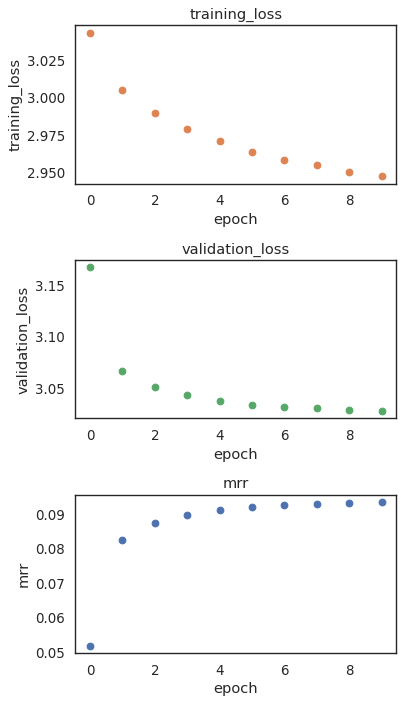

In [48]:
si.pl.pbg_metrics(fig_ncol=1)

In [49]:
si.pl.pbg_metrics(fig_ncol=1,save_fig=True,fig_name='graph0_model.pdf')

## Post-training Analysis

In [50]:
palette_celltype={'TAC-1':'#F8D856', 'TAC-2':'#F1B044', 'IRS':'#C37777', 
              'Medulla':'#897a74','Hair Shaft-cuticle.cortex':"#d6a780"}

In [51]:
dict_adata = si.read_embedding()

In [52]:
dict_adata

{'P': AnnData object with n_obs × n_vars = 332987 × 50,
 'M': AnnData object with n_obs × n_vars = 884 × 50,
 'G': AnnData object with n_obs × n_vars = 17399 × 50,
 'C': AnnData object with n_obs × n_vars = 6436 × 50,
 'K': AnnData object with n_obs × n_vars = 4096 × 50}

In [53]:
adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes
adata_P = dict_adata['P']  # embeddings for peaks
adata_K = dict_adata['K']  # embeddings for kmers
adata_M = dict_adata['M']  # embeddings for motifs

#### to distinguish TF motifs from gene names
adata_M.obs.index = 'M_'+adata_M.obs.index

In [54]:
adata_C

AnnData object with n_obs × n_vars = 6436 × 50

In [55]:
adata_G

AnnData object with n_obs × n_vars = 17399 × 50

In [56]:
adata_P

AnnData object with n_obs × n_vars = 332987 × 50

### visualize embeddings of cells

In [57]:
## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy()

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [58]:
adata_C

AnnData object with n_obs × n_vars = 6436 × 50
    obs: 'celltype'

In [59]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)

In [60]:
adata_C

AnnData object with n_obs × n_vars = 6436 × 50
    obs: 'celltype'
    obsm: 'X_umap'

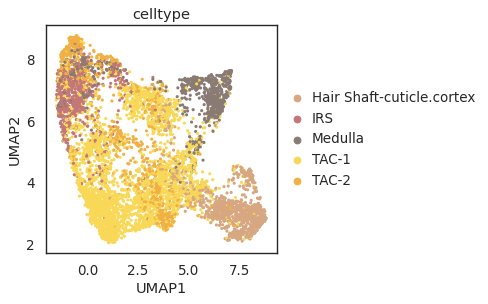

In [227]:
si.pl.umap(adata_C,color=['celltype'],dict_palette={'celltype': palette_celltype},fig_size=(6,4),
           drawing_order='random')

In [228]:
si.pl.umap(adata_C,color=['celltype'],dict_palette={'celltype': palette_celltype},fig_size=(6,4),
           drawing_order='random',
           save_fig=True,
           fig_name='umap_graph0_model.pdf')

### visualize embeddings of cells and genes

In [65]:
adata_all_CG = si.tl.embed(adata_ref=adata_C,
                           list_adata_query=[adata_G])

Performing softmax transformation for query data 0;


In [66]:
## add annotations of all entities
adata_all_CG.obs['entity_anno'] = ""
adata_all_CG.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all_CG.obs.loc[adata_C.obs_names, 'celltype'].tolist()
adata_all_CG.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'

In [229]:
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "#607e95"

In [71]:
si.tl.umap(adata_all_CG,n_neighbors=15,n_components=2)

In [72]:
adata_all_CG.obs.head()

,celltype,id_dataset,entity_anno
Trial60.skin.R1.02.R2.47.R3.02.P1.54,TAC-2,ref,TAC-2
Trial60.skin.R1.51.R2.48.R3.30.P1.54,IRS,ref,IRS
Trial60.skin.R1.64.R2.52.R3.11.P1.54,Medulla,ref,Medulla
Trial60.skin.R1.74.R2.04.R3.13.P1.55,TAC-1,ref,TAC-1
Trial60.skin.R1.94.R2.40.R3.61.P1.55,Hair Shaft-cuticle.cortex,ref,Hair Shaft-cuticle.cortex


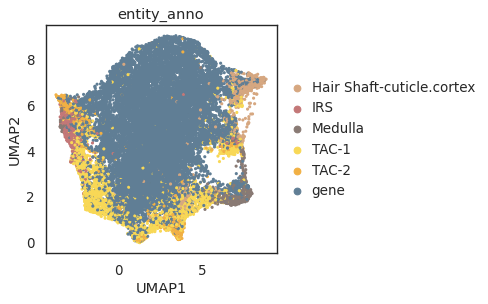

In [230]:
si.pl.umap(adata_all_CG,
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           fig_size=(6,4),
           drawing_order='random')

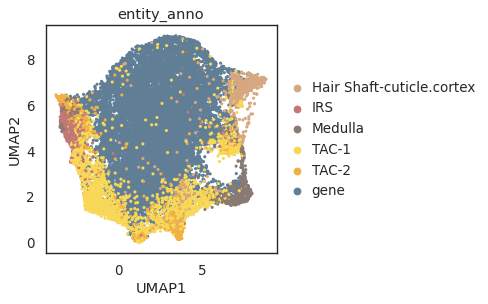

In [231]:
si.pl.umap(adata_all_CG[::-1,],
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           fig_size=(6,4),
           drawing_order='original')

```python
published_markers = ['Mki67','Top2a','Mcm2',### TAC1
                     'Shh','Wnt10b','Fbp1',### TAC2
                     'Krt27','Foxq1','Krt75',### medulla
                     'Krt31','Selenbp1','Rnaset2b', ##hair shaft/cuticle/cortex
                     'Krt71',### IRS
                    ]
```

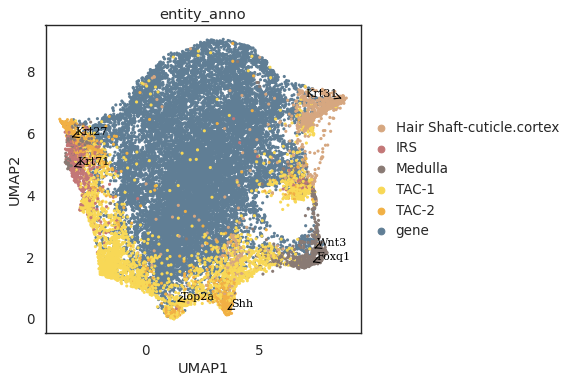

In [232]:
si.pl.umap(adata_all_CG[::-1,],
           color=['entity_anno'],dict_palette={'entity_anno': palette_entity_anno},
           fig_size=(7,5),
           texts=['Wnt3','Top2a','Shh','Krt27','Foxq1', 'Krt31','Krt71'],
           text_expand=(1.5,1.2),
           show_texts=True,
           drawing_order='original', fig_legend_ncol=1, alpha=1)

### visualize embeddings of cells, genes, TF, and kmers

In [80]:
adata_all_CGMK = si.tl.embed(adata_ref=adata_C,
                             list_adata_query=[adata_G, adata_M, adata_K])

Performing softmax transformation for query data 0;
Performing softmax transformation for query data 1;
Performing softmax transformation for query data 2;


In [81]:
## add annotations of all entities
adata_all_CGMK.obs['entity_anno'] = ""
adata_all_CGMK.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all_CGMK.obs.loc[adata_C.obs_names, 'celltype'].tolist()
adata_all_CGMK.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'
adata_all_CGMK.obs.loc[adata_K.obs_names, 'entity_anno'] = 'kmer'
adata_all_CGMK.obs.loc[adata_M.obs_names, 'entity_anno'] = 'motif'

In [141]:
si.tl.umap(adata_all_CGMK,n_neighbors=50,n_components=2)

In [233]:
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "#607e95"
palette_entity_anno['kmer'] = "#94b1b7"
palette_entity_anno['motif'] = "#92ba79"

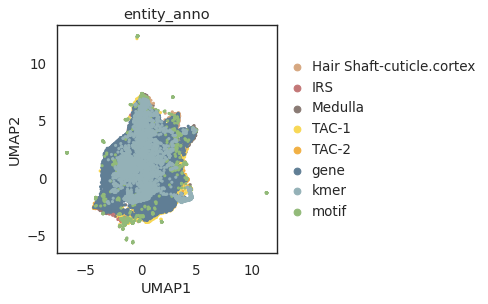

In [234]:
si.pl.umap(adata_all_CGMK,
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           fig_size=(6,4),
           drawing_order='original')

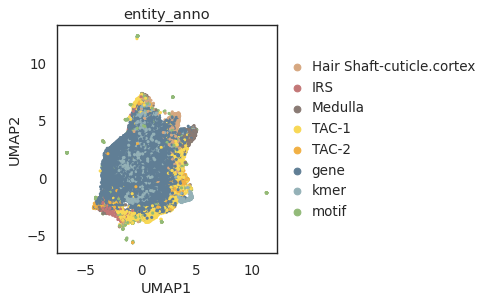

In [235]:
si.pl.umap(adata_all_CGMK,
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           fig_size=(6,4),
           drawing_order='random')

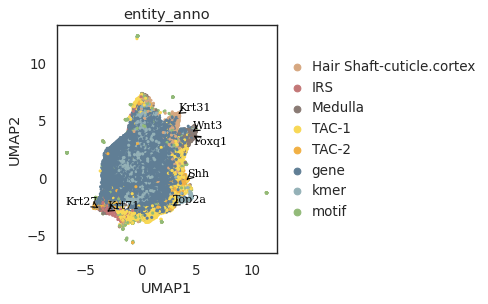

In [236]:
si.pl.umap(adata_all_CGMK,
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           texts=['Wnt3','Top2a','Shh','Krt27','Foxq1', 'Krt31','Krt71'],
           show_texts=True,
           fig_size=(6,4),
           drawing_order='random')

### visualize embeddings of all

In [86]:
adata_all = si.tl.embed(adata_ref=adata_C,
                        list_adata_query=[adata_G, adata_M, adata_K, adata_P])

Performing softmax transformation for query data 0;
Performing softmax transformation for query data 1;
Performing softmax transformation for query data 2;
Performing softmax transformation for query data 3;


In [87]:
## add annotations of all entities
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'celltype'].tolist()
adata_all.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'
adata_all.obs.loc[adata_P.obs_names, 'entity_anno'] = 'peak'
adata_all.obs.loc[adata_K.obs_names, 'entity_anno'] = 'kmer'
adata_all.obs.loc[adata_M.obs_names, 'entity_anno'] = 'motif'

In [88]:
adata_all

AnnData object with n_obs × n_vars = 361802 × 50
    obs: 'celltype', 'id_dataset', 'entity_anno'

In [137]:
%%time
si.tl.umap(adata_all,n_neighbors=50,n_components=2,n_jobs=20)

CPU times: user 13min 53s, sys: 3min 4s, total: 16min 57s
Wall time: 10min 38s


In [237]:
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "#607e95"
palette_entity_anno['kmer'] = "#94b1b7"
palette_entity_anno['motif'] = "#92ba79"
palette_entity_anno['peak'] = "#e5c2c8"

Trying to set attribute `.uns` of view, copying.


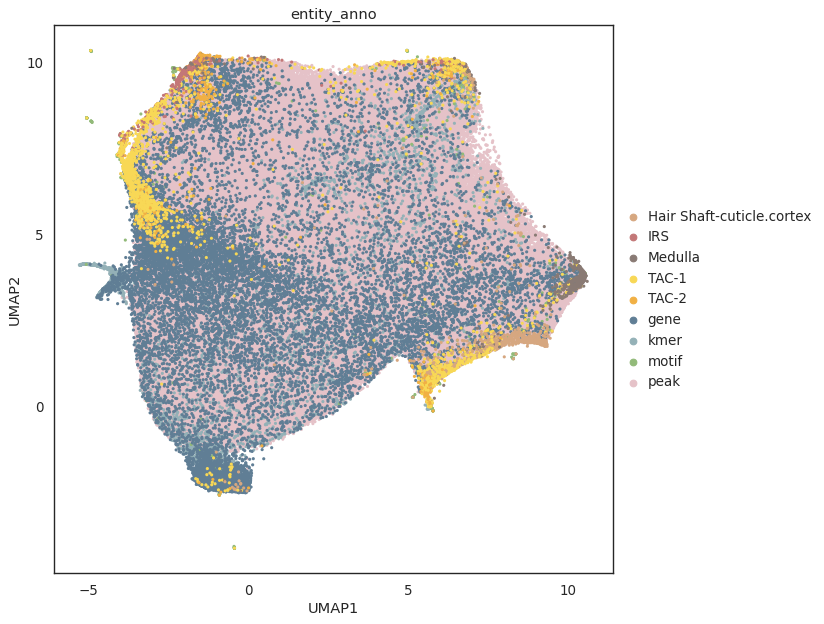

In [238]:
si.pl.umap(adata_all[::-1,],
           color=['entity_anno'],dict_palette={'entity_anno': palette_entity_anno},
           fig_size=(10,8),
           drawing_order='original',
           texts=['Wnt3','Top2a','Shh','Krt27','Foxq1', 'Krt31','Krt71'],
           show_texts=False,)

Trying to set attribute `.uns` of view, copying.


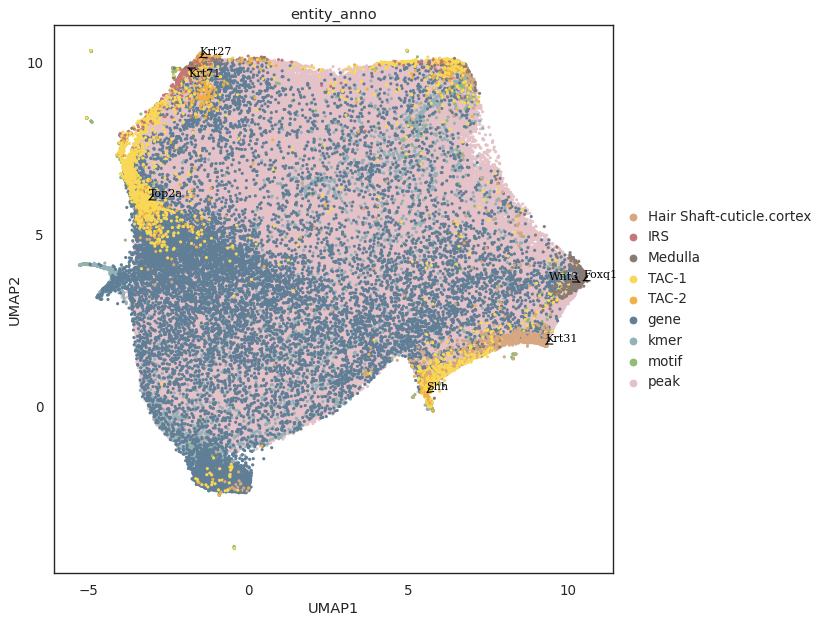

In [239]:
si.pl.umap(adata_all[::-1,],color=['entity_anno'],dict_palette={'entity_anno': palette_entity_anno},fig_size=(10,8),
           drawing_order='original',
           texts=['Wnt3','Top2a','Shh','Krt27','Foxq1', 'Krt31','Krt71'],
           show_texts=True,)

#### calculate gene scores

In [247]:
adata_CG_atac = si.tl.gene_scores(adata_CP,genome='mm10',use_gene_weigt=True,use_top_pcs=False)

Using precomputed overlap


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [249]:
adata_CG_atac

AnnData object with n_obs × n_vars = 6436 × 35976
    obs: 'depth', 'FRIP', 'TSSportion', 'EnhancerPortion', 'atac.barcode', 'rna.barcode', 'atac.umap1', 'atac.umap2', 'celltype', 'rna.umap1', 'rna.umap2', 'n_counts', 'n_peaks', 'pct_peaks', 'pbg_id'
    var: 'chr', 'start', 'end', 'symbol', 'strand'

In [250]:
adata_CP

AnnData object with n_obs × n_vars = 6436 × 332987
    obs: 'depth', 'FRIP', 'TSSportion', 'EnhancerPortion', 'atac.barcode', 'rna.barcode', 'atac.umap1', 'atac.umap2', 'celltype', 'rna.umap1', 'rna.umap2', 'n_counts', 'n_peaks', 'pct_peaks', 'pbg_id'
    var: 'chr', 'start', 'end', 'width', 'strand', 'TSSidx', 'Enhanceridx', 'Gene', 'peaks', 'n_counts', 'n_cells', 'pct_cells', 'pbg_id'
    uns: 'gene_scores'

In [251]:
si.pp.filter_genes(adata_CG_atac,min_n_cells=3)
si.pp.cal_qc_rna(adata_CG_atac)
si.pp.normalize(adata_CG_atac,method='lib_size')
si.pp.log_transform(adata_CG_atac)

Before filtering: 
6436 cells, 35976 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
6436 cells, 27357 genes


In [253]:
adata_CG.write(os.path.join(workdir,'adata_CG.h5ad'))
adata_CP.write(os.path.join(workdir,'adata_CP.h5ad'))
adata_PM.write(os.path.join(workdir,'adata_PM.h5ad'))
adata_PK.write(os.path.join(workdir,'adata_PK.h5ad'))

adata_C.write(os.path.join(workdir,'adata_C.h5ad'))
adata_G.write(os.path.join(workdir,'adata_G.h5ad'))
adata_P.write(os.path.join(workdir,'adata_P.h5ad'))
adata_K.write(os.path.join(workdir,'adata_K.h5ad'))
adata_M.write(os.path.join(workdir,'adata_M.h5ad'))

adata_CG_atac.write(os.path.join(workdir,'adata_CG_atac.h5ad'))

adata_all_CG.write(os.path.join(workdir,'adata_all_CG.h5ad'))
adata_all_CGMK.write(os.path.join(workdir,'adata_all_CGMK.h5ad'))
adata_all.write(os.path.join(workdir,'adata_all.h5ad'))

... storing 'chr' as categorical
... storing 'strand' as categorical
... storing 'celltype' as categorical
... storing 'id_dataset' as categorical
... storing 'entity_anno' as categorical
... storing 'celltype' as categorical
... storing 'id_dataset' as categorical
... storing 'entity_anno' as categorical
... storing 'celltype' as categorical
... storing 'id_dataset' as categorical
... storing 'entity_anno' as categorical
